In [66]:
import libtempo_py as lt
import numpy as np
import os

In [67]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [20, 6]

In [183]:
audio_file = '../data/riders.mp3'
ref_tempo = 60
bpm_range = (30, 630)
merge_truth_threshold = 10  # s
merge_labels_threshold = 4  # s
section_length_thresh = 60

In [184]:
audio = lt.audio.AudioFile.open(audio_file)
audio_mono = np.mean(audio.data, axis=0)

In [185]:
# Novelty curve
novelty_curve, novelty_curve_sr = lt.audio_to_novelty_curve(audio_mono, audio.sr)

In [186]:
# Tempogram
tempogram_y_axis = np.arange(*bpm_range)
tempogram, t = lt.novelty_curve_to_tempogram(novelty_curve, tempogram_y_axis, novelty_curve_sr, 8)
cyclic_tempogram, cyclic_tempogram_y_axis = lt.tempogram_to_cyclic_tempogram(tempogram, tempogram_y_axis, ref_tempo=ref_tempo)
smoothed_tempogram = lt.smoothen_tempogram(cyclic_tempogram, cyclic_tempogram_y_axis, t, 20)

In [187]:
 # Tempo sections
tempo_curve = lt.tempogram_to_tempo_curve(smoothed_tempogram, cyclic_tempogram_y_axis)
tempo_curve = lt.correct_tempo_curve(tempo_curve, t, 5)
tempo_sections = lt.curve_to_sections(tempo_curve, t, ref_tempo, 100000, 1.5)
if tempo_sections[-1].end > len(novelty_curve) / novelty_curve_sr: tempo_sections[-1].end -= 0.1
tempo_sections = lt.sections_extract_offset(novelty_curve, tempo_sections, [1, 2, 4], novelty_curve_sr, bpm_doubt_window=5)

In [188]:
len(tempo_sections)

10

In [189]:
def get_bars(section, compound_bar_size = 1):
    bar_length = 60 / section.bpm * 4
    combined_bar_length = bar_length * compound_bar_size
    combined_bar_length_samples = int(np.round(combined_bar_length * novelty_curve_sr))
    
    cursor = section.offset
    if cursor < 0: cursor += bar_length
    
    ret = []
    while cursor + combined_bar_length <= section.end:
        start = int(np.round(cursor * novelty_curve_sr))
        
        ret.append(novelty_curve[start:start + combined_bar_length_samples])
        
        cursor += combined_bar_length
    
    return ret

In [190]:
def calculate_section_bar(section, compound_bar_size = 1, compare_history_size=2, plot = False):
    bars = get_bars(section, compound_bar_size)
    if len(bars) < compare_history_size: return 0
    
    compare_history_size_half = int(compare_history_size / 2)
    
    intensity = 0
    bar_intensities = []
    for i in range(len(bars)):
        bar_intensity = bars[i] * np.ones_like(bars[i])
        for j in range(i - compare_history_size_half, i + compare_history_size_half):
            if j == i: continue
            bar_intensity *= bars[j % len(bars)]
        bar_intensity -= np.mean(bar_intensity)
        bar_intensity[bar_intensity < 0] = 0
        
        bar_intensities.append(bar_intensity)
        intensity += sum(bar_intensity)
        
    if plot:
        for bar in bar_intensities: plt.plot(bar)
    plt.show()
    print(f'Int count: {len(bar_intensities)}')
    print(f'BPM: {section.bpm * (1/ compound_bar_size)}')
    print(f'Weighted: {intensity * compound_bar_size}')
        
    return intensity

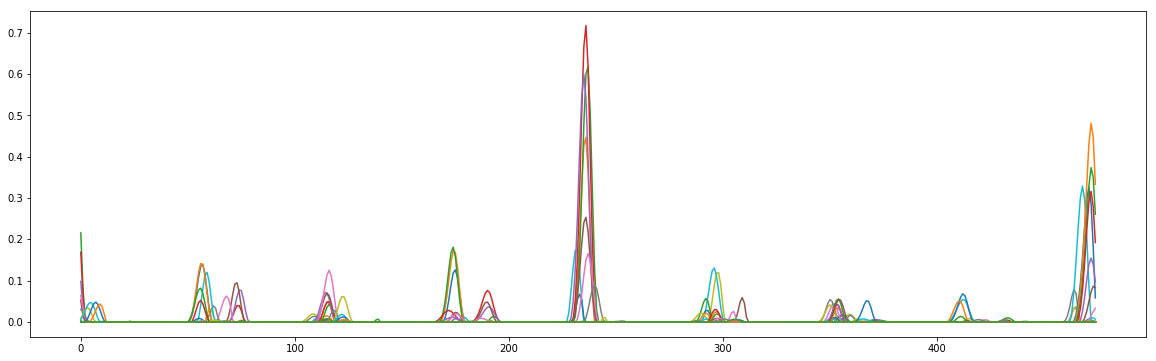

Int count: 43
BPM: 101.08417544854672
Weighted: 46.31934171833836
46.31934171833836


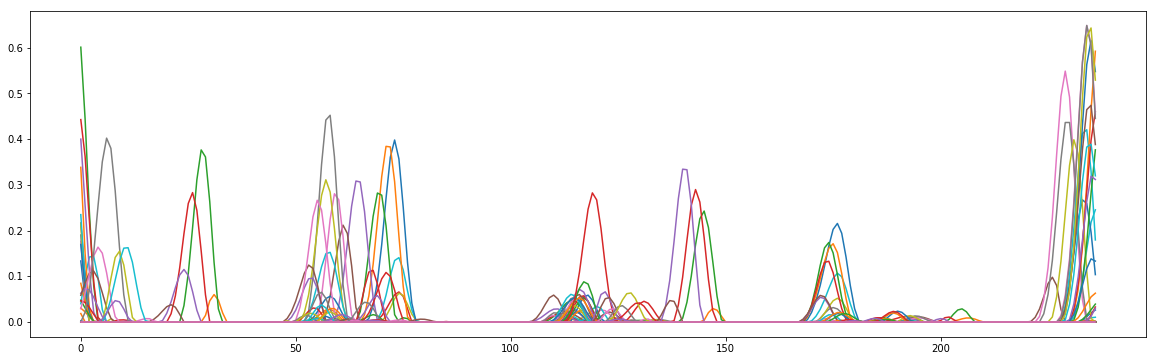

Int count: 87
BPM: 202.16835089709343
Weighted: 45.2596645278347
90.5193290556694


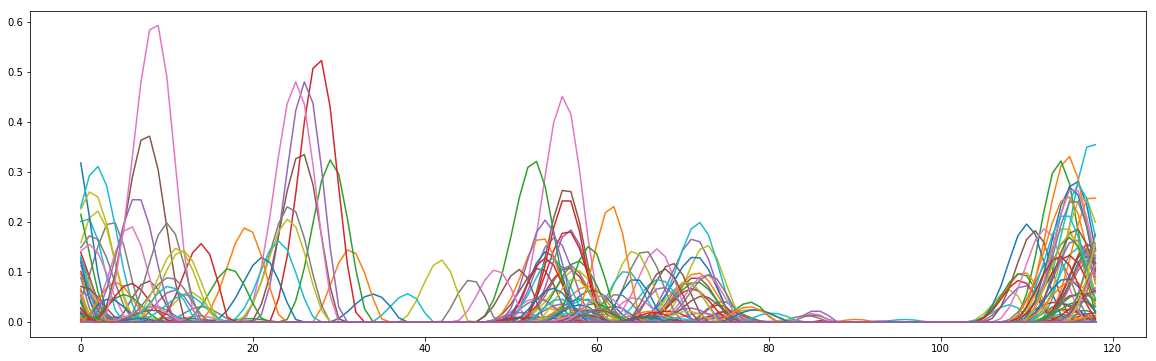

Int count: 175
BPM: 404.33670179418687
Weighted: 29.319064532394254
117.27625812957702


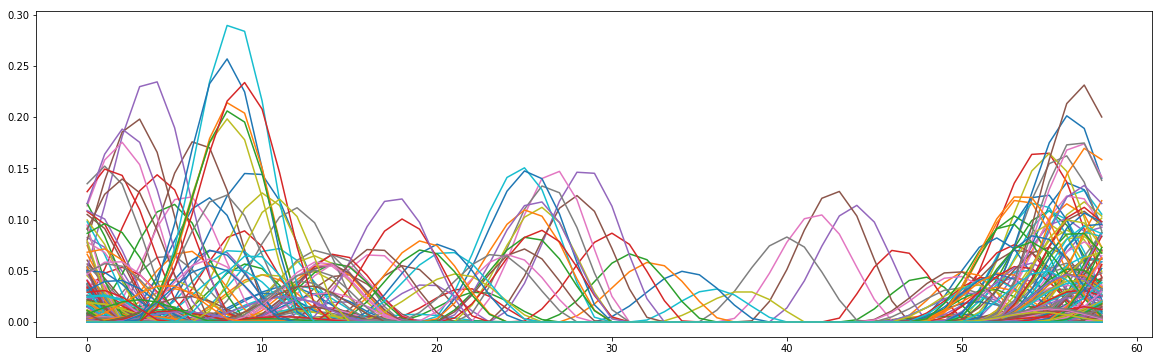

Int count: 350
BPM: 808.6734035883737
Weighted: 11.06217691426505
88.4974153141204


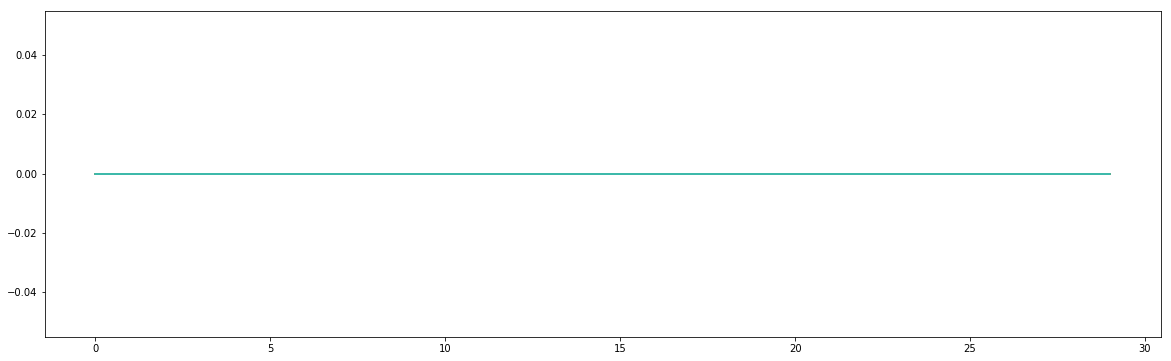

Int count: 700
BPM: 1617.3468071767475
Weighted: 0.0
0.0


In [191]:
section_i = 2
h_size = 4
print(calculate_section_bar(tempo_sections[section_i], compound_bar_size = 1, plot=True, compare_history_size=h_size))
print(calculate_section_bar(tempo_sections[section_i], compound_bar_size = 1/2, plot=True, compare_history_size=h_size))
print(calculate_section_bar(tempo_sections[section_i], compound_bar_size = 1/4, plot=True, compare_history_size=h_size))
print(calculate_section_bar(tempo_sections[section_i], compound_bar_size = 1/8, plot=True, compare_history_size=h_size))
print(calculate_section_bar(tempo_sections[section_i], compound_bar_size = 1/16, plot=True, compare_history_size=h_size))